Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Examples of lazy resampling compose

This notebook provides basic examples of lazy resampling preprocessing using `monai.transforms.Compose`.

Combining multiple spatial transforms to have a single step resampling can potentially reduce the computational time and memory footprint, at the same time generate results with less interpolation errors.

The first few cells define data preparation and visualisations. These are provided to make this notebook self-contained.
The usage of `Compose` is mainly covered by the last few sections.

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm, gdown]"

## Setup imports

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import monai
from monai.visualize import matshow3d
import monai.transforms as mt
from monai.config import print_config

print_config()

## Preparing the data and utilities

This section downloads a testing dataset and prepare a utility function for inspecting the results.

In [3]:
def plot_img_operations(pair, every_n=10):
    if isinstance(pair, list):
        print(f"metadata of patch idx 0 out of {len(pair)} samples.\n")
        p_0 = pair[0]
    else:
        p_0 = pair
    print("\n")
    p_0 = p_0["image"]
    if len(p_0.shape) > 4:
        p_0 = monai.utils.first(p_0)
    print(f"pixdim: {p_0.pixdim}")
    print(f"shape: {p_0.shape}")
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    matshow3d(pair["image"], every_n=every_n, fig=plt.gca())
    plt.subplot(1, 2, 2)
    matshow3d(pair["label"], every_n=every_n, fig=plt.gca())
    plt.show()


sample_url = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases"
sample_url += "/download/0.8.1/totalSegmentator_mergedLabel_samples.zip"
monai.apps.download_and_extract(sample_url, filepath="samples.zip")
img_name = "./totalSegmentator_mergedLabel_samples/imagesTr/s0001.nii.gz"
seg_name = "./totalSegmentator_mergedLabel_samples/labelsTr/s0001.nii.gz"
filenames = {"image": img_name, "label": seg_name}

2023-04-19 21:45:43,620 - INFO - Expected md5 is None, skip md5 check for file samples.zip.
2023-04-19 21:45:43,621 - INFO - File exists: samples.zip, skipped downloading.
2023-04-19 21:45:43,621 - INFO - Writing into directory: ..


## Load and visualize the volume



pixdim: tensor([1.0000, 0.5000, 0.5000], dtype=torch.float64)
shape: torch.Size([1, 319, 562, 745])


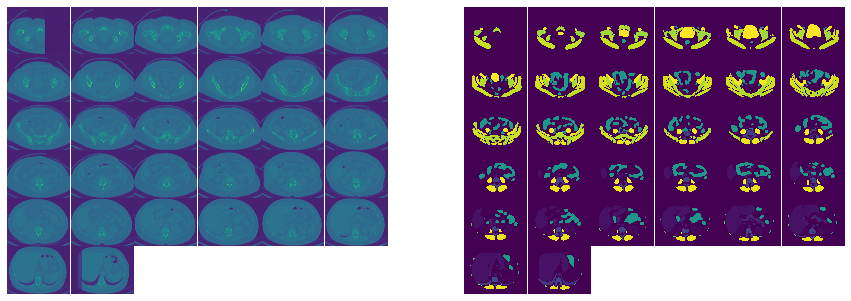

In [4]:
data = mt.LoadImageD(keys=("image", "label"), image_only=True, ensure_channel_first=True)(filenames)

orientation = mt.OrientationD(keys=("image", "label"), axcodes="SPL")  # Superior, Posterior, Left
spacing = mt.SpacingD(keys=("image", "label"), pixdim=(1.0, 0.5, 0.5), mode=("bilinear", "nearest"))

transform = mt.Compose([orientation, spacing])
data = transform(data)

plot_img_operations(data)

In [5]:
print("unique class labels", np.unique(data["label"]))

unique class labels [  0.   1.   2.   3.   5.   6.   7.   8.   9.  10.  11.  12.  14.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  51.  52.  53.  54.  55.  56.
  57.  65.  66.  67.  68.  69.  77.  78.  79.  80.  81.  88.  89.  90.
  91.  92.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104.]


## The preprocessing pipeline

The following cell creates a typical preprocessing pipeline for training segmentation models.

More specifically, 
- the image volumes are loaded from the file system, and are normalised to a pre-defined orientation and voxel resolution;
- multiple image patch samples are generated from the volumes (with `num_samples` patches per volume), with a sampling strategy that computes feasible sampling locations from the labels;
- each image patch is randomly (and independently) transformed as data augmentations.

During these processes, the corresponding label of each image are also transformed with the same parameters as the image.

However, different data types and interpolation modes are used to make sure the segmentation masks contain discrete values.



In [6]:
monai.utils.set_determinism(24)
patch_size = (20, 200, 200)
num_classes = 104
num_samples = 4
device = "cuda:0" if torch.cuda.is_available() else "cpu"
transform_list = [
    mt.LoadImageD(keys=("image", "label"), image_only=True, ensure_channel_first=True),
    mt.EnsureTypeD(keys=("image", "label"), device=device),
    mt.OrientationD(keys=("image", "label"), axcodes="SPL"),
    mt.SpacingD(keys=("image", "label"), pixdim=(1.0, 0.5, 0.5), mode=("bilinear", "nearest")),
    mt.CastToTypeD(keys=("image", "label"), dtype=(torch.float, torch.uint8)),
    mt.RandCropByLabelClassesD(
        keys=("image", "label"),
        label_key="label",
        num_classes=num_classes,
        num_samples=num_samples,
        spatial_size=patch_size,
        warn=False,
    ),
    mt.RandRotateD(
        keys=("image", "label"), prob=1.0, range_x=0.0, range_y=0.0, range_z=0.3, mode=("bilinear", "nearest")
    ),
    mt.RandZoomD(keys=("image", "label"), prob=1.0, min_zoom=0.8, max_zoom=1.2, mode=("trilinear", "nearest")),
    mt.RandGaussianSmoothD(keys="image", prob=1.0, sigma_x=(0.5, 1.15), sigma_y=(0.5, 1.15), sigma_z=(0.5, 1.15)),
    mt.RandScaleIntensityD(keys="image", prob=1.0, factors=0.3),
    mt.RandShiftIntensityD(keys="image", prob=1.0, offsets=0.1),
    mt.RandGaussianNoiseD(keys="image", prob=1.0, std=0.01),
    mt.RandFlipD(keys=("image", "label"), prob=1.0, spatial_axis=0),
    mt.RandFlipD(keys=("image", "label"), prob=1.0, spatial_axis=1),
    mt.RandFlipD(keys=("image", "label"), prob=1.0, spatial_axis=2),
    mt.CastToTypeD(keys=("image", "label"), dtype=(torch.float, torch.uint8)),
]

xform = mt.Compose(transform_list)
dataset = monai.data.Dataset([filenames], transform=xform)
data_loader = monai.data.DataLoader(dataset, batch_size=1)
for item in data_loader:
    print(item.keys())

dict_keys(['image', 'label'])




pixdim: tensor([1.0523, 0.5082, 0.5076], dtype=torch.float64)
shape: torch.Size([1, 20, 200, 200])


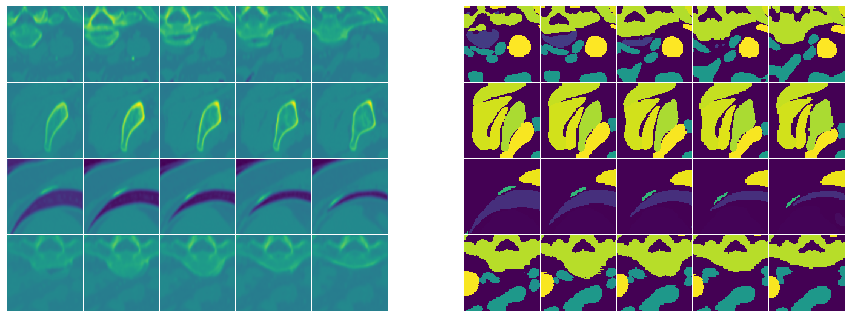

In [7]:
plot_img_operations(item, every_n=4)

In [8]:
item["image"].pixdim

[tensor([1.0523, 0.5082, 0.5076], dtype=torch.float64),
 tensor([1.0965, 0.5620, 0.5348], dtype=torch.float64),
 tensor([0.9515, 0.4625, 0.4608], dtype=torch.float64),
 tensor([0.9282, 0.5027, 0.4587], dtype=torch.float64)]

## The preprocessing pipeline evaluated lazily

To enable lazy resampling, it's possible to go through each item in `transform_list` to set the `lazy_evaluation` flag.
Simple options are also provided within `monai.transforms.Compose` to achieve the same goal:

``lazy_evaluation=True`` will make all `LazyTransform` execute lazily whenever possible.

``override_keys``, ``overrides`` specify the additional resampling parameters when the pending operations of the transforms' outcome are evaluated.

By default, the pending operations are not automatically executed. It is therefore important to review the transform list before enabling the lazy resampling flag.

In this particular example, we need to modify the original preprocessing steps in two places:

- Because the `RandCropByLabelClassesD` relies on the `label` input to compute feasible sampling locations, it's necessary to clear any pending operations on `label` and make sure the primary label data are up-to-date.
- Element-wise operations such as `RandGaussianSmoothD` will be more efficient if they are applied to the cropped image patches instead of the volumes in the original spatial shape.

To have the flexibility of evaluating the pending operations anywhere within a pipeline,
`Compose` detects `Identity` or `IdentityD` transforms and always evaluate the MetaTensors' pending operations before applying the subsequent transforms.

The following cell adds `IdentityD` transforms to the `transform_list` and modifies the `Compose` call, in order to execute the lazy resampling correctly.

In [9]:
monai.utils.set_determinism(24)
transform_list.insert(5, mt.IdentityD(keys="label"))
transform_list.insert(8, mt.IdentityD(keys="image"))
for idx, t in enumerate(transform_list):
    print(f"{idx} -- {t.__class__.__name__}")

xform = mt.Compose(
    transform_list, lazy_evaluation=True, override_keys=("image", "label"), overrides={"mode": ("bilinear", "nearest")}
)
dataset = monai.data.Dataset([filenames], transform=xform)
data_loader = monai.data.DataLoader(dataset, batch_size=1)
for item_lazy in data_loader:
    print(item_lazy.keys())

0 -- LoadImaged
1 -- EnsureTyped
2 -- Orientationd
3 -- Spacingd
4 -- CastToTyped
5 -- Identityd
6 -- RandCropByLabelClassesd
7 -- RandRotated
8 -- Identityd
9 -- RandZoomd
10 -- RandGaussianSmoothd
11 -- RandScaleIntensityd
12 -- RandShiftIntensityd
13 -- RandGaussianNoised
14 -- RandFlipd
15 -- RandFlipd
16 -- RandFlipd
17 -- CastToTyped
dict_keys(['image', 'label'])




pixdim: tensor([1.0523, 0.5082, 0.5076], dtype=torch.float64)
shape: torch.Size([1, 20, 200, 200])


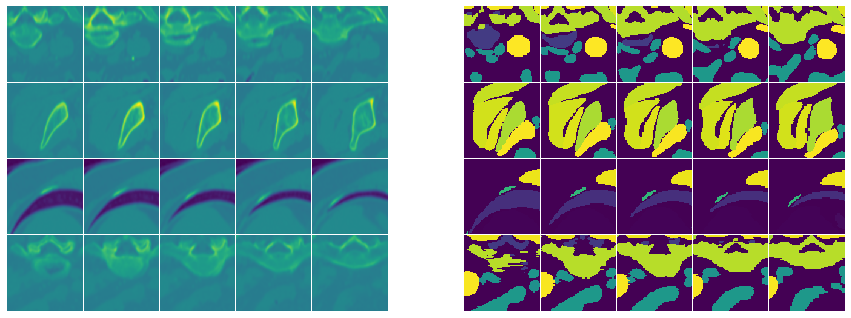

In [10]:
plot_img_operations(item_lazy, every_n=4)

In [11]:
item_lazy["image"].pixdim

[tensor([1.0523, 0.5082, 0.5076], dtype=torch.float64),
 tensor([1.0965, 0.5620, 0.5348], dtype=torch.float64),
 tensor([0.9515, 0.4625, 0.4608], dtype=torch.float64),
 tensor([0.9282, 0.5027, 0.4587], dtype=torch.float64)]

When `lazy_evaluation=True`, `Compose` will automatically try to clear the MetaTensors' `pending_operations` before returning the final transform outputs. As a result, the outcomes of the dataloader are fully evaluated transformed samples.

## Voxel-wise differences between the regular approach and lazy resampling

As expected, using the updated pipeline doesn't change the system parameters of the transforms,
but the actual resampling results are slightly different.

The discrepencies are mainly from different numbers of resampling steps. Lazy resampling is expected to better preserve the original image intensity information when it fuses multiple resampling steps as one.

In [12]:
print(item_lazy["image"].affine - item["image"].affine)

tensor([[[ 0.0000e+00,  0.0000e+00,  1.1102e-16, -2.8422e-14],
         [-1.7347e-18,  2.2204e-16,  0.0000e+00, -4.2633e-14],
         [ 2.2204e-16, -6.9389e-18,  0.0000e+00,  2.8422e-14],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-1.3878e-17,  2.6021e-18,  0.0000e+00,  0.0000e+00],
         [ 1.3878e-17,  0.0000e+00,  1.7347e-18,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  6.9389e-18,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-6.9389e-18,  3.4694e-18,  5.5511e-17, -2.8422e-14],
         [ 0.0000e+00, -5.5511e-17,  1.7347e-18,  7.1054e-15],
         [ 3.3307e-16,  0.0000e+00,  3.4694e-18, -5.6843e-14],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 1.3878e-17,  6.9389e-18,  1.1102e-16, -4.9738e-14],
         [ 0.0000e+00,  5.5511e-17, -1.7347e-18,  7.1054e-14],
         [ 1.1102e-16,  0.0000e+00,  3.4694e-18,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, 



pixdim: tensor([1.0523, 0.5082, 0.5076], dtype=torch.float64)
shape: torch.Size([1, 20, 200, 200])


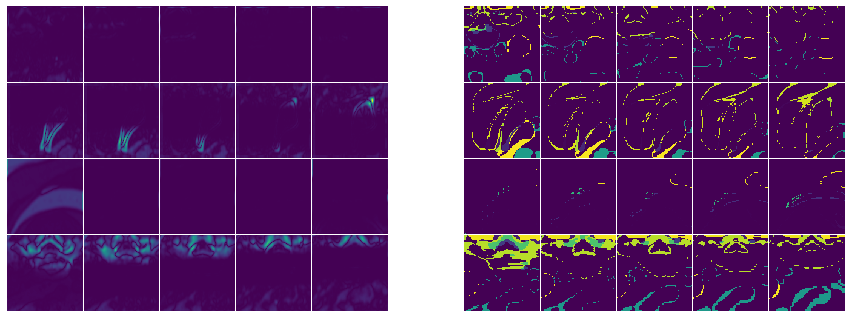

In [13]:
diffs = {}
for k in item_lazy:
    diffs[k] = torch.abs(item_lazy[k] - item[k])
plot_img_operations(diffs, every_n=4)

## An alternative approach of using `Compose` to lazily combine transforms

The following example shows that subsets of transforms can be lazily grouped together using `Compose(..., lazy_evaluation=True, ...)`. The main difference compared with the previous approach, is that when the composed transforms are used with a cache-based dataset, the caching points becomes right before the inner `Compose`. Because `Compose` is a subclass of `Randomizable`.

dict_keys(['image', 'label'])


pixdim: tensor([1.0523, 0.5082, 0.5076], dtype=torch.float64)
shape: torch.Size([1, 20, 200, 200])


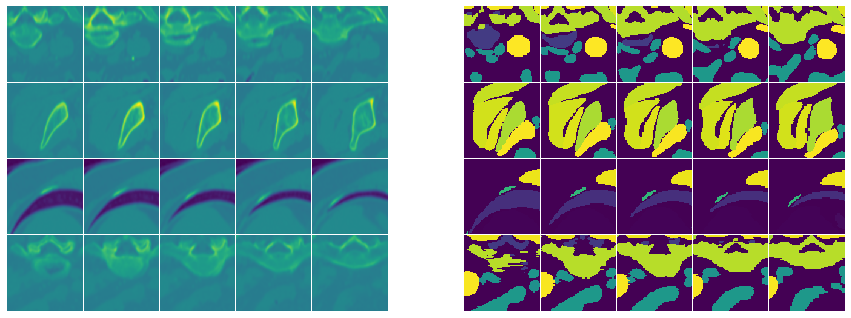

In [19]:
monai.utils.set_determinism(24)
patch_size = (20, 200, 200)
num_classes = 104
num_samples = 4
device = "cuda:0" if torch.cuda.is_available() else "cpu"
xform = mt.Compose(
    [
        mt.LoadImageD(keys=("image", "label"), image_only=True, ensure_channel_first=True),
        mt.EnsureTypeD(keys=("image", "label"), device=device),
        mt.Compose(
            [
                mt.OrientationD(keys=("image", "label"), axcodes="SPL"),
                mt.SpacingD(keys=("image", "label"), pixdim=(1.0, 0.5, 0.5), mode=("bilinear", "nearest")),
                mt.CastToTypeD(keys=("image", "label"), dtype=(torch.float, torch.uint8)),
                mt.IdentityD(keys="label"),
                mt.RandCropByLabelClassesD(
                    keys=("image", "label"),
                    label_key="label",
                    num_classes=num_classes,
                    num_samples=num_samples,
                    spatial_size=patch_size,
                    warn=False,
                ),
                mt.RandRotateD(
                    keys=("image", "label"),
                    prob=1.0,
                    range_x=0.0,
                    range_y=0.0,
                    range_z=0.3,
                    mode=("bilinear", "nearest"),
                ),
                mt.RandZoomD(
                    keys=("image", "label"), prob=1.0, min_zoom=0.8, max_zoom=1.2, mode=("trilinear", "nearest")
                ),
                mt.RandFlipD(keys=("image", "label"), prob=1.0, spatial_axis=0),
                mt.RandFlipD(keys=("image", "label"), prob=1.0, spatial_axis=1),
                mt.RandFlipD(keys=("image", "label"), prob=1.0, spatial_axis=2),
            ],
            lazy_evaluation=True,
            override_keys=("image", "label"),
            overrides={"mode": ("bilinear", "nearest")},
        ),
        mt.RandGaussianSmoothD(keys="image", prob=1.0, sigma_x=(0.5, 1.15), sigma_y=(0.5, 1.15), sigma_z=(0.5, 1.15)),
        mt.RandScaleIntensityD(keys="image", prob=1.0, factors=0.3),
        mt.RandShiftIntensityD(keys="image", prob=1.0, offsets=0.1),
        mt.RandGaussianNoiseD(keys="image", prob=1.0, std=0.01),
        mt.CastToTypeD(keys=("image", "label"), dtype=(torch.float, torch.uint8)),
    ]
)
dataset = monai.data.Dataset([filenames], transform=xform)
data_loader = monai.data.DataLoader(dataset, batch_size=1)
for item in data_loader:
    print(item.keys())
plot_img_operations(item_lazy, every_n=4)